<h1> Task 1 - Setting the baseline <h1>

<h2> Task 1.1 - Data preparation and validation pipeline <h2>

<h3> Import librarys <h3>

In [32]:
import matplotlib.pyplot as plt                        # Library for plotting graphs and visualizations
import numpy as np                                     # Library for numerical computing (arrays, math functions)
import pandas as pd                                    # Library for handling datasets (tables, CSVs, DataFrames)
from sklearn.metrics import mean_squared_error , root_mean_squared_error  # Function to evaluate model performance using MSE
from sklearn.model_selection import train_test_split   # Utility to split dataset into training and testing sets
from sklearn.preprocessing import StandardScaler       # Tool to normalize/standardize features
from sklearn.preprocessing import PolynomialFeatures   # Generates polynomial features for non-linear regression
from sklearn.pipeline import make_pipeline             # Builds pipelines that chain preprocessing + model steps
from sklearn.linear_model import LinearRegression      # Ordinary least squares linear regression model
from sklearn.linear_model import Ridge, RidgeCV        # Ridge regression (L2 regularization) and Ridge with cross-validation
from sklearn.compose import ColumnTransformer          # Apply transformations to specific columns of the dataset
from sklearn.preprocessing import FunctionTransformer  # Apply custom functions to transform data
from sklearn.neighbors import KNeighborsRegressor      # k-Nearest Neighbors regression model
from sklearn.multioutput import MultiOutputRegressor   # Extend regressors to multi-output problems
import math                                            # Python built-in math library
import time                                            # Python built-in library to measure execution time
import seaborn as sns                                  #Statistical data visualization                           
import os                                              #Python built-in library for operating system interactions
import missingno as msno                               #Library for visualizing missing data
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, cross_validate #Cross-validation utilities


<h3> Missing data visualization <h3>

<Axes: >

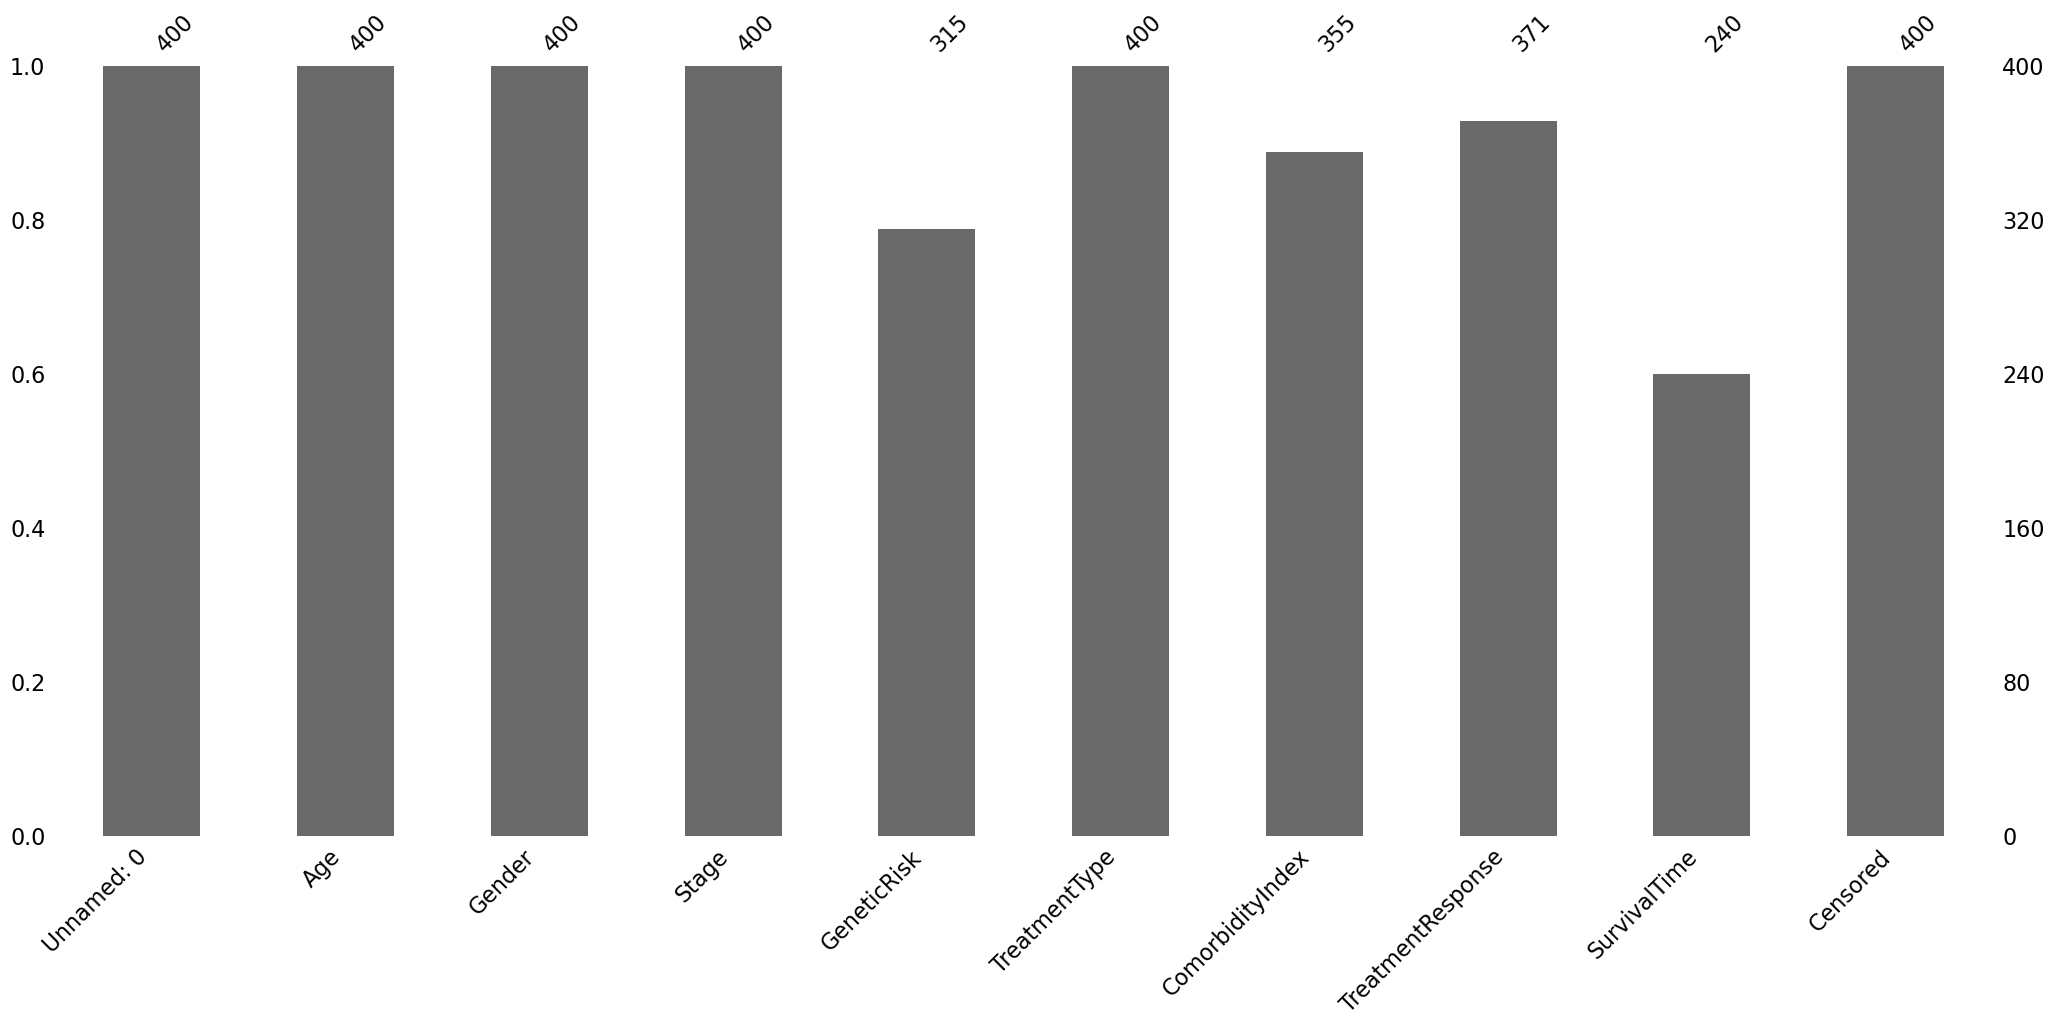

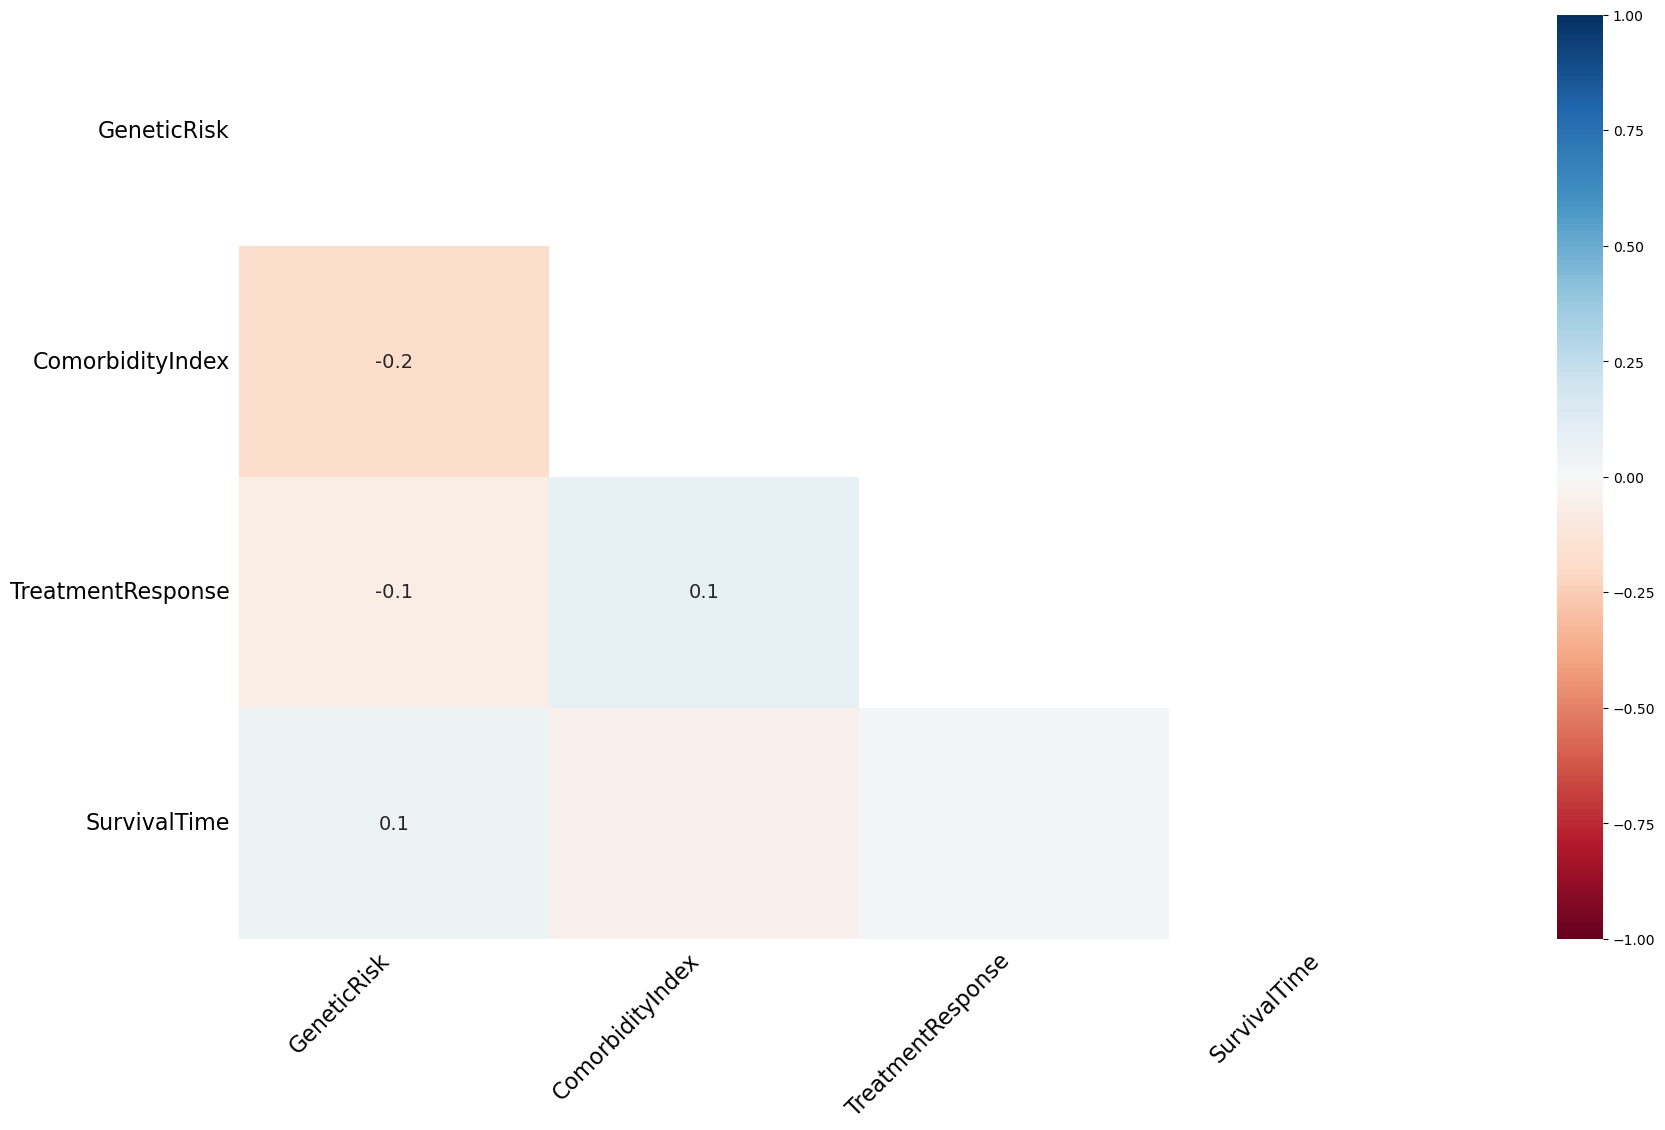

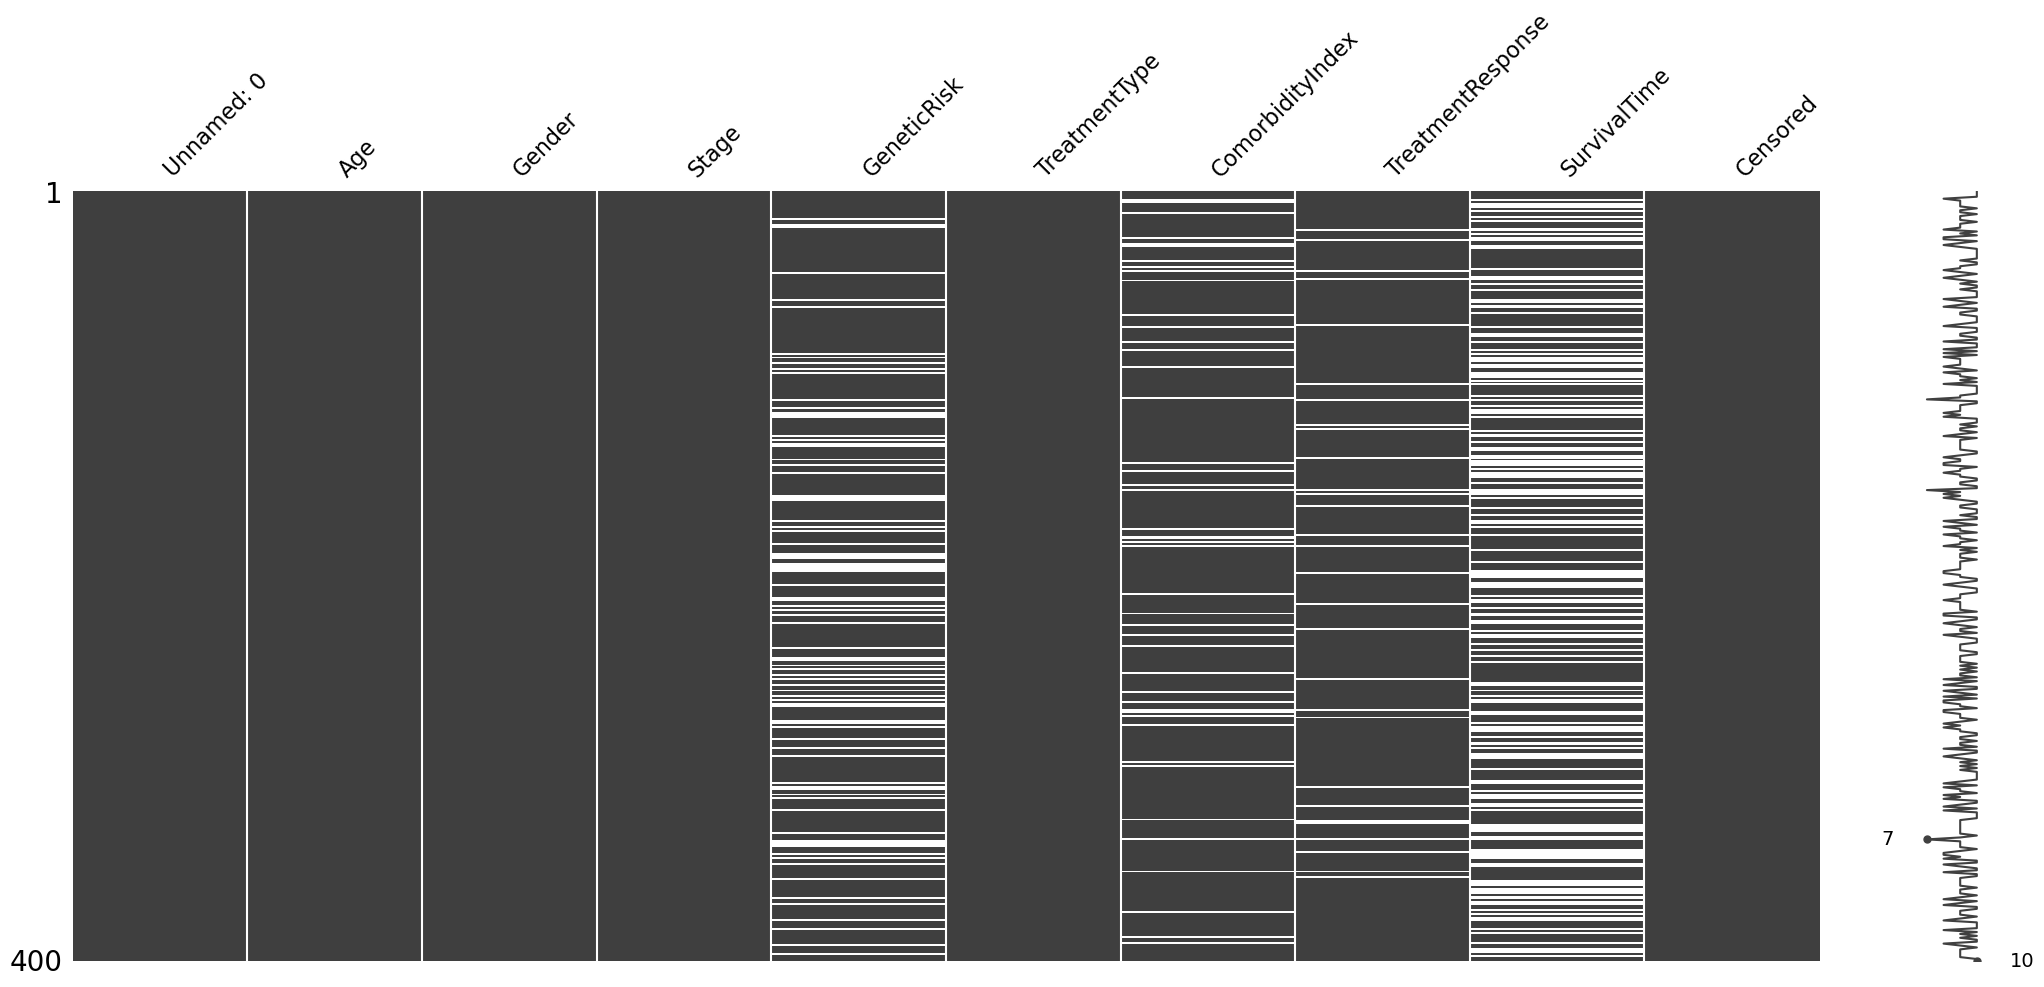

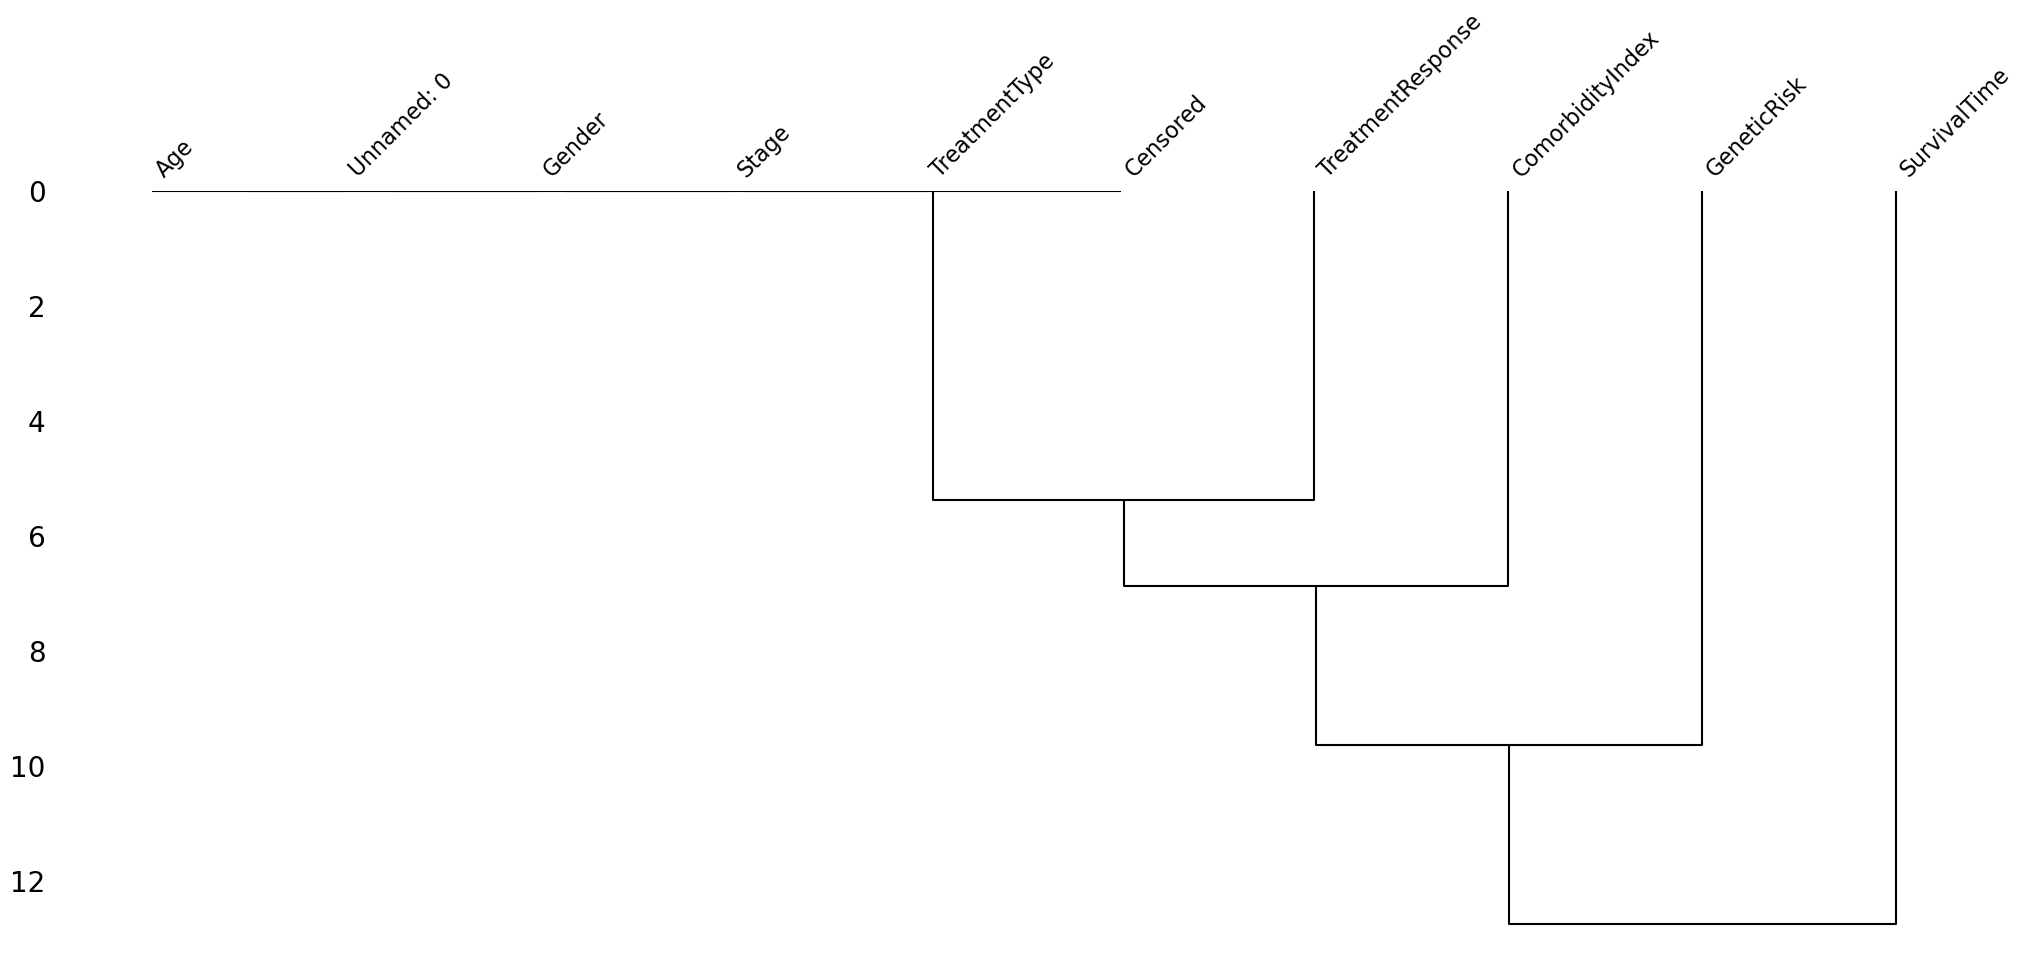

In [33]:
train = pd.read_csv("../data/train_data.csv")
test  = pd.read_csv("../data/test_data.csv")

msno.bar(train)
msno.heatmap(train)
msno.matrix(train)
msno.dendrogram(train)                                        

<h3> Droupout lines: missing values and censored <h3>

In [34]:
#Dataset Analysis before the droupout
print("Initial Analysis of the training set:")
print(f"Total training exemples: {len(train)}")
print(f"\nMissing values per column:")
print(train.isnull().sum())
print(f"Censored exemples: {train['Censored'].sum()} ({100*train['Censored'].sum()/len(train):.1f}%)")
print(f"Non Censored exemples: {(train['Censored']==0).sum()} ({100*(train['Censored']==0).sum()/len(train):.1f}%)")

#Droupout lines with missing values 
#Columns with missing values
cols_to_check = ["TreatmentResponse", "GeneticRisk", "ComorbidityIndex", "SurvivalTime"]

#Remove every line with at least one missing value in the specified columns
train_clean = train.dropna(subset=cols_to_check)
print("Number of lines without missing values:", len(train_clean))

#Dropout lines with censored
#Remove every line with Censored=1
train_final = train_clean[train_clean["Censored"] == 0]

print("Number of lines withou censored values:", len(train_final))

Initial Analysis of the training set:
Total training exemples: 400

Missing values per column:
Unnamed: 0             0
Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64
Censored exemples: 79 (19.8%)
Non Censored exemples: 321 (80.2%)
Number of lines without missing values: 153
Number of lines withou censored values: 109


<h3> Pairplot between target (Survival Time) and Features <h3>

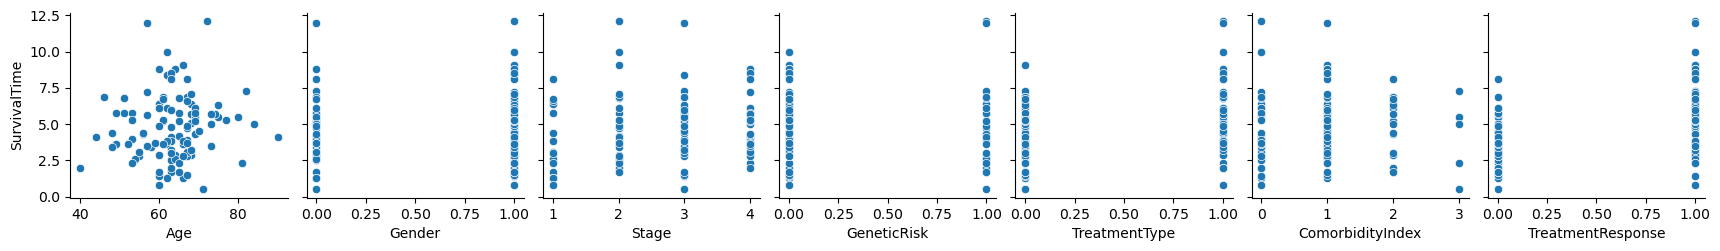

In [35]:
#Define target and features
target = "SurvivalTime"
features = [
    "Age", "Gender", "Stage", "GeneticRisk",
    "TreatmentType", "ComorbidityIndex",
    "TreatmentResponse"]

df = train_final[features + [target]]

#Creating pairplot
sns.pairplot(df, y_vars=[target], x_vars=features)
plt.show()

<h3> Matrix of X and vector of Y <h3>

In [36]:
#Creating the matrix and the vector 
X = train_final[features].values  
y = train_final["SurvivalTime"].values  

<h3> Comparing Splitting Strategies <h3>

In [37]:
n_total = len(train_final)

#Train/Val/Test split (60/20/20)
train_size_1 = int(0.6 * n_total)
val_size_1 = int(0.2 * n_total)
test_size_1 = n_total - train_size_1 - val_size_1

print(f"Train/Val/Test (60/20/20):")
print(f"Train: {train_size_1} exemples")
print(f"Val: {val_size_1} exemples")
print(f"Test: {test_size_1} exemples")

#Train/Test + 5-Fold CV
train_size_2 = int(0.8 * n_total)
test_size_2 = n_total - train_size_2

print(f"Train/Test (80/20) + 5-Fold CV:")
print(f"Train: {train_size_2} exemplos")
print(f"Test: {test_size_2} exemplos")
print(f"Each fold in train in CV: ~{int(0.8 * train_size_2)} exemples")
print(f"Each fold in validation in CV: ~{int(0.2 * train_size_2)} exemples")

Train/Val/Test (60/20/20):
Train: 65 exemples
Val: 21 exemples
Test: 23 exemples
Train/Test (80/20) + 5-Fold CV:
Train: 87 exemplos
Test: 22 exemplos
Each fold in train in CV: ~69 exemples
Each fold in validation in CV: ~17 exemples


<h3> Defining new metric cMSE <h3>

In [38]:
def error_metric(y, y_hat, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

<h2> Task 1.2 - Learn the baseline model <h2>

Train size: 87
Test size: 22
Cross-validated MSE: 4.298554921105085
Final Test MSE: 3.9983211203636304


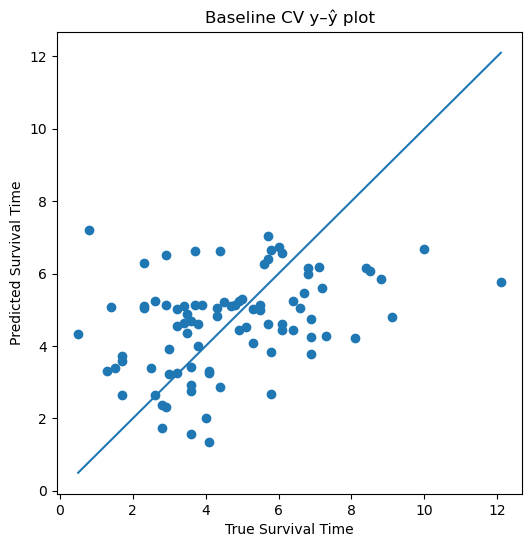

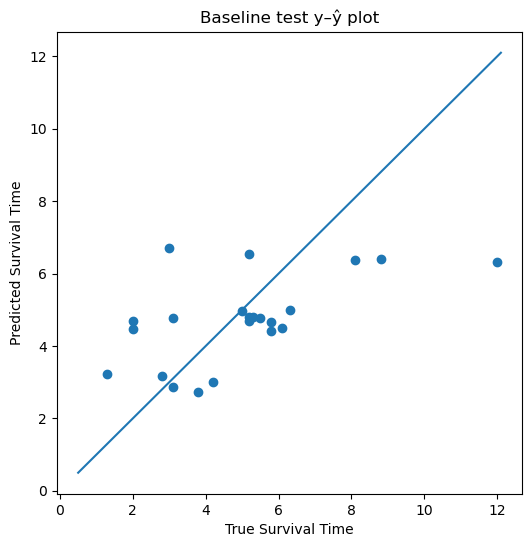

In [39]:
#Splitting the dataset for Cross Validation
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    X,
    y,
    train_final["Censored"].values,  # inclui censura aqui
    test_size=0.2,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

#Baseline model with Linear Regression and Standard Scaler
baseline = make_pipeline(StandardScaler(with_mean=True), LinearRegression())

#Cross-validation to evaluate the baseline model
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_hat_cv = cross_val_predict(baseline, X_train, y_train, cv=cv)

mse_cv =mean_squared_error(y_train, y_hat_cv)
print("Cross-validated MSE:", mse_cv)

#Fitting the baseline model
baseline.fit(X_train, y_train)
y_test_hat = baseline.predict(X_test)

#Using MSE as error metric beacause for data with c=0 MSE=cMSE
mse_test = mean_squared_error(y_test, y_test_hat)
print("Final Test MSE:", mse_test)

#Y_y_hat plot
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_hat_cv)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline CV y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_hat)
plt.xlabel("True Survival Time")
plt.ylabel("Predicted Survival Time")
plt.title("Baseline test y–ŷ plot")
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.show()

In [40]:
#Kaggle submission
baseline.fit(X, y)  
test_pred = baseline.predict(test[features])

sub = pd.DataFrame({
    "PatientID": test["PatientID"],
    "SurvivalTime": test_pred
})

sub.to_csv("baseline-submission-01.csv", index=False)
print("Submission saved as baseline-submission-01.csv")

c:\Users\DESKTOP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<h1> Task 2 - Nonlinear models <h2>

<h2> Tssk 2.1 - Development <h2>

<h3> Polynomial Model <h3>

In [ ]:
#Define the regressor by Ridge regularization to use in the pipeline
def pick_regressor(use_ridge=False, ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)): #Defining the value of lambda for Ridge regularization(penalty term)
    if use_ridge:
        alphas_array = np.array(ridge_alphas)  # If ridge is used, convert the alphas to a numpy array
        regressor = RidgeCV(alphas=alphas_array)  # The model is a linear regression with Ridge
    else:
        regressor = LinearRegression()  # If ridge is not used, the model is a simple linear regression
    return regressor

#Creates a validation function for polynomial regression models to choose the best degree and model
def train_polynomial_cv(
    X_train, y_train,  #Split data from the make_train_val_test_split function
    degrees=range(1, 8),
    cv=5, 
    random_state=42,
    use_ridge=False,
    ridge_alphas=(0.01, 0.1, 1.0, 10.0, 100.0)):
    
    #Cross-validation setup
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {
        'degrees': [],
        'n_features': [],
        'mse_train': [],
        'mse_cv': []}
    
    #Training for each degree
    for degree in degrees:
        #Create pipeline with StandardScaler, PolynomialFeatures, and chosen regressor
        regr = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
        model = make_pipeline(
            StandardScaler(with_mean=True),
            PolynomialFeatures(degree=degree, include_bias=False),
            regr)
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()

        #Train on full training set to get training error
        model.fit(X_train, y_train)
        n_features = model.named_steps['polynomialfeatures'].n_output_features_
        
        #Store results
        results['degrees'].append(degree)
        results['n_features'].append(n_features)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        print(f"Degree {degree}:"
              f"Number features = {n_features}, "
              f"Train MSE = {mse_train:.2f}, "
              f"CV MSE = {mse_cv:.2f}")
    
    #Select best degree (lowest CV MSE)
    best_idx = np.argmin(results['mse_cv'])
    best_degree = results['degrees'][best_idx]
    best_cv_mse = results['mse_cv'][best_idx]
    
    print(f"BEST POLYNOMIAL DEGREE: {best_degree} (CV MSE = {best_cv_mse:.2f})")

    # Train final model with best degree - FIXED
    regr_final = pick_regressor(use_ridge=use_ridge, ridge_alphas=ridge_alphas)
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        PolynomialFeatures(degree=best_degree, include_bias=False),
        regr_final)

    best_model.fit(X_train, y_train)
    
    return best_model, results

def plot_polynomial_results(results_linear, results_ridge, save_path=None):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. MSE vs Degree
    ax = axes[0, 0]
    ax.plot(results_linear['degrees'], results_linear['mse_train'], 
            'o-', label='Train (No Ridge)', color='blue', alpha=0.7)
    ax.plot(results_linear['degrees'], results_linear['mse_cv'], 
            's-', label='CV (No Ridge)', color='blue')
    ax.plot(results_ridge['degrees'], results_ridge['mse_train'], 
            'o-', label='Train (Ridge)', color='red', alpha=0.7)
    ax.plot(results_ridge['degrees'], results_ridge['mse_cv'], 
            's-', label='CV (Ridge)', color='red')
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('MSE')
    ax.set_title('MSE vs Polynomial Degree')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Feature Complexity
    ax = axes[0, 1]
    ax.plot(results_linear['degrees'], results_linear['n_features'], 
            'o-', label='Number of Features', color='green', linewidth=2)
    ax.set_xlabel('Polynomial Degree')
    ax.set_ylabel('Number of Features')
    ax.set_title('Model Complexity (Feature Count)')
    ax.legend()
    ax.grid(True, alpha=0.3)


In [ ]:
#Polynomial Regression without Ridge regularization
print("Polynomial Regression Without Ridge Regularization")

poly_model_linear, poly_results_linear = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=False, 
    random_state=42)

#Polynomial Regression without Ridge regularization
print("Polynomial Regression With Ridge Regularization")

poly_model_ridge, poly_results_ridge = train_polynomial_cv(
    X_train, y_train, 
    degrees=range(1, 6),  
    cv=5,
    use_ridge=True, 
    ridge_alphas=(0.1, 1.0, 10.0, 100.0, 1000.0),  
    random_state=42)

Polynomial Regression Without Ridge Regularization
Degree 1:Number features = 7, Train MSE = 3.03, CV MSE = 4.29
Degree 2:Number features = 35, Train MSE = 1.73, CV MSE = 5.27
Degree 3:Number features = 119, Train MSE = 0.00, CV MSE = 334007186663589212585984.00
Degree 4:Number features = 329, Train MSE = 0.00, CV MSE = 13707905065545725952.00
Degree 5:Number features = 791, Train MSE = 0.00, CV MSE = 40487480162421448704.00
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.29)
Polynomial Regression With Ridge Regularization
Degree 1:Number features = 7, Train MSE = 3.06, CV MSE = 4.11
Degree 2:Number features = 35, Train MSE = 2.66, CV MSE = 4.86
Degree 3:Number features = 119, Train MSE = 2.60, CV MSE = 5.10
Degree 4:Number features = 329, Train MSE = 2.63, CV MSE = 5.01
Degree 5:Number features = 791, Train MSE = 1.85, CV MSE = 5.62
BEST POLYNOMIAL DEGREE: 1 (CV MSE = 4.11)


<h3> KNN Model <h3>

In [ ]:
#k-Nearest Neighbors regression with Cross-Validation to choose the best k
def train_knn_cv(X_train, y_train, k_values=range(1, 30), cv=5, random_state=42):
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    results = {'k_values': [], 'mse_train': [], 'mse_cv': [], 'std_cv': []}
    
    print("k-Nearest Neighbors:")
    
    #Training for each k
    for k in k_values:
        model = make_pipeline(
            StandardScaler(with_mean=True),
            KNeighborsRegressor(n_neighbors=k))
        
        #Cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        
        cv_results = cross_validate(
            model, X_train, y_train,
            cv=cv_splitter,
            scoring='neg_mean_squared_error',
            return_train_score=True,
            n_jobs=-1)
        
        mse_train = -cv_results['train_score'].mean()
        mse_cv = -cv_results['test_score'].mean()
        
        model.fit(X_train, y_train)
        
        results['k_values'].append(k)
        results['mse_train'].append(mse_train)
        results['mse_cv'].append(mse_cv)
        
        if k <= 10 or k % 5 == 0:
            print(f"k={k:2d}: Train MSE={mse_train:.2f}, CV MSE={mse_cv:.2f}")
    
    best_idx = np.argmin(results['mse_cv'])
    best_k = results['k_values'][best_idx]
    print(f"\nBEST k: {best_k} (CV MSE = {results['mse_cv'][best_idx]:.2f})")
    
    best_model = make_pipeline(
        StandardScaler(with_mean=True),
        KNeighborsRegressor(n_neighbors=best_k)
    )
    best_model.fit(X_train, y_train)
    
    return best_model, results

In [ ]:
knn_model, knn_results = train_knn_cv(
        X_train, y_train,
        k_values=range(1, 30), 
        cv=5,
        random_state=42)

k-Nearest Neighbors:
k= 1: Train MSE=0.00, CV MSE=8.83
k= 2: Train MSE=1.89, CV MSE=5.86
k= 3: Train MSE=2.24, CV MSE=5.06
k= 4: Train MSE=2.63, CV MSE=4.71
k= 5: Train MSE=2.83, CV MSE=4.75
k= 6: Train MSE=2.87, CV MSE=4.34
k= 7: Train MSE=2.98, CV MSE=4.23
k= 8: Train MSE=3.01, CV MSE=4.15
k= 9: Train MSE=3.13, CV MSE=4.35
k=10: Train MSE=3.22, CV MSE=4.21
k=15: Train MSE=3.41, CV MSE=3.87
k=20: Train MSE=3.50, CV MSE=3.89
k=25: Train MSE=3.69, CV MSE=4.05

BEST k: 15 (CV MSE = 3.87)


<h2> Task 2.2 - Evaluation <h2>

In [ ]:
#Comprehensive evaluation function
def evaluate_model_comprehensive(model, X_train, y_train, X_test, y_test, 
                                 model_name, cv=5, random_state=42):

    #Cross-validation predictions on training set
    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv_splitter)
    
    #Train set predictions (refit on full training set)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    #Test set predictions
    y_test_pred = model.predict(X_test)
    
    #Calculate errors
    train_errors = y_train - y_train_pred
    cv_errors = y_train - y_train_pred_cv
    test_errors = y_test - y_test_pred
    
    #Compile results
    results = {
        'Model': model_name,
        
        # Training and Cross-Validation Metrics
        'Train_MSE': mean_squared_error(y_train, y_train_pred),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'CV_MSE': mean_squared_error(y_train, y_train_pred_cv),
        'CV_RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_cv)),
        
        # Test Set Metrics
        'Test_MSE': mean_squared_error(y_test, y_test_pred),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))}
        
    return results

#Function to compare multiple models
def compare_models(models_dict, X_train, y_train, X_test, y_test, cv=5, random_state=42):
    
    all_results = []

    for model_name, model in models_dict.items():
        results = evaluate_model_comprehensive(
            model, X_train, y_train, X_test, y_test, 
            model_name, cv, random_state)
        all_results.append(results)
    
    #Create comprehensive DataFrame
    results_df = pd.DataFrame([{k: v for k, v in r.items() 
                                if k not in ['y_test_pred', 'test_errors']} 
                               for r in all_results])
    
    return results_df, all_results

def print_comparison_tables(results_df):

    #Main metrics table
    main_metrics = results_df[['Model', 'Train_MSE', 'CV_MSE', 'Test_MSE', 
                                'Train_RMSE', 'CV_RMSE', 'Test_RMSE']].copy()
    print(main_metrics.to_string(index=False))
    
    print("Ranking of Models Based on Test MSE:")
    #Ranking
    ranking = results_df[['Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']].copy()
    ranking = ranking.sort_values('Test_MSE')
    ranking['Rank'] = range(1, len(ranking) + 1)
    ranking = ranking[['Rank', 'Model', 'Test_MSE', 'Test_RMSE', 'CV_MSE']]
    print(ranking.to_string(index=False))
    
    #Print best model
    best_model = ranking.iloc[0]
    print(f"Best Model: {best_model['Model']}")
    print(f"Test MSE: {best_model['Test_MSE']:.4f}")
    print(f"Test RMSE: {best_model['Test_RMSE']:.4f}")    
    return ranking

#Function to plot model comparison with MSE values
def plot_model_comparison(results_df, all_results, y_test):
    
    n_models = len(results_df)
    x_pos = np.arange(n_models)
    width = 0.25
    plt.figure(figsize=(12, 6))
    plt.bar(x_pos - width, results_df['Train_MSE'], width, label='Train MSE', alpha=0.8)
    plt.bar(x_pos, results_df['CV_MSE'], width, label='CV MSE', alpha=0.8)
    plt.bar(x_pos + width, results_df['Test_MSE'], width, label='Test MSE', alpha=0.8)
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.title('MSE Comparison Across Models')
    plt.xticks(x_pos, results_df['Model'], rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

                       Model  Train_MSE   CV_MSE  Test_MSE  Train_RMSE  CV_RMSE  Test_RMSE
Baseline (Linear Regression)   3.143587 4.298555  3.998321    1.773016 2.073296   1.999580
 Polynomial Ridge (Degree 1)   3.161014 4.108471  4.045532    1.777924 2.026936   2.011351
                 k-NN (k=15)   3.293437 3.854053  4.741620    1.814783 1.963174   2.177526
Ranking of Models Based on Test MSE:
 Rank                        Model  Test_MSE  Test_RMSE   CV_MSE
    1 Baseline (Linear Regression)  3.998321   1.999580 4.298555
    2  Polynomial Ridge (Degree 1)  4.045532   2.011351 4.108471
    3                  k-NN (k=15)  4.741620   2.177526 3.854053
Best Model: Baseline (Linear Regression)
Test MSE: 3.9983
Test RMSE: 1.9996


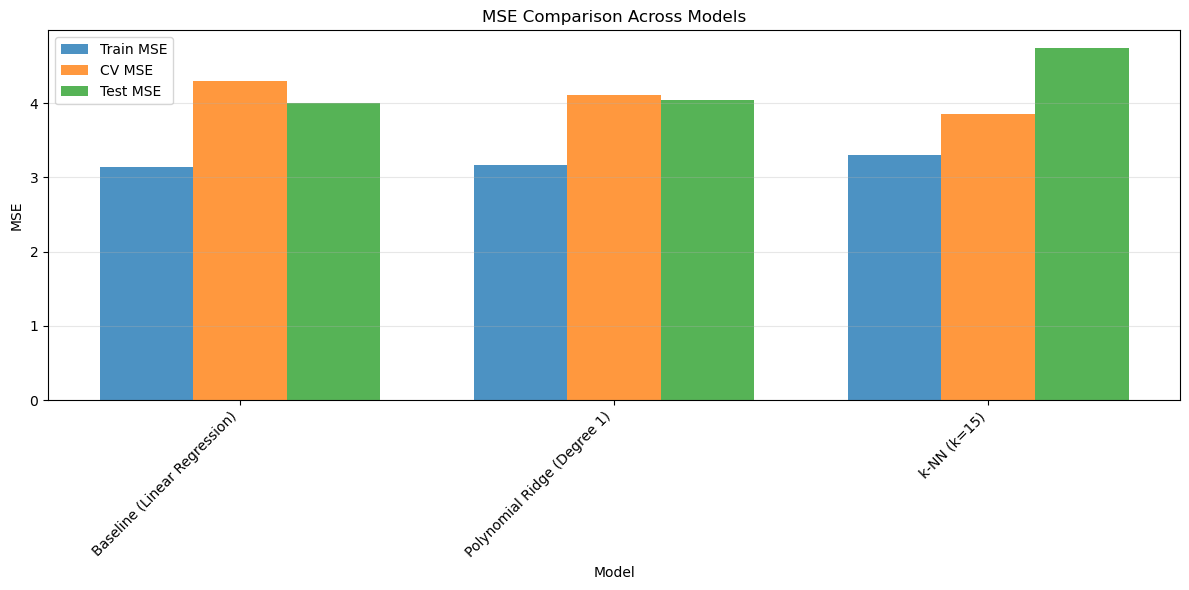

In [ ]:
#Defining models to compare
models_dict = {
    'Baseline (Linear Regression)': baseline,
    'Polynomial Ridge (Degree 1)': poly_model_ridge,
    'k-NN (k=15)': knn_model}

#Comprehensive comparison
results_df, all_results = compare_models(
    models_dict, X_train, y_train, X_test, y_test, 
    cv=5, random_state=42)
    
#rint comparison tables
ranking = print_comparison_tables(results_df)
    
#Create plot
plot_model_comparison (results_df, all_results, y_test)